##### 3: Soil Water Content

This section provides instructions to analyzing soil volumetric water content (SWC) data downloaded from NEON using `neonUtilities`. Generally, Soil volumetric water content is recorded at various depths below the soil surface from 6 cm down to 200 cm at non-permafrost sites (down to 300 cm at Alaskan sites).

###### 3.1 Understanding Soil Moisture Data:

- NEON records SWC data at various depths (typically 6 cm to 200 cm) for non-permafrost sites.
- Data comes from five instrumented plots per site, with 1-minute and 30-minute averages.
- Due to ongoing data product corrections, sensor position data is provided in a separate file (swc_depthsV2.csv) within the downloaded package.

###### 3.2 Downloading Sensor Positions (if necessary):

The code snippet demonstrates how to download the swc_depthsV2.csv file using requests if it's not automatically included.

In [15]:
import requests
import pandas as pd
url = "https://data.neonscience.org/documents/10179/11206/swc_depthsV2/77eee1a6-4de5-6746-4471-ab3a61c7685b"
response = requests.get(url)
if response.status_code == 200:
    sensor_p = pd.read_csv(url)
    print("Sensor position data loaded successfully.")
else:
    print("Failed to download the sensor position file.")

Sensor position data loaded successfully.


###### 3.3 Downloaded Files and Loading Data:

Use `os.listdir('saved/path')` to verify downloaded files in the specified path.
We'll work with the 30-minute data (SWS_30_minute.csv) for demonstration.
The code loads the data into a pandas DataFrame (SWS_30_Minute), converts the startDateTime to datetime format, and sets it as the index.

- Loading Soil Volumetric Water Content Data
We start by loading the soil VWC data, focusing on 30-minute intervals for demonstration purposes.

In [16]:
path = '/Volumes/Thomas/Tutorials/NEON/Data/filesToStack00094/stackedFiles/SWS_30_minute.csv'
soil_vwc_data = pd.read_csv(path)
soil_vwc_data['startDateTime'] = pd.to_datetime(soil_vwc_data['startDateTime'])
soil_vwc_data.set_index('startDateTime', inplace=True)

**Data Organization and Cleaning**
- We'll average data for all plots  (horizontalPosition == 1 to 5) at the TALL site (siteID == 'TALL').
- Select relevant columns from the DataFrame (columns_of_interest).
- Filter the data to remove rows with poor data quality (VSICFinalQF != 0).
- Group the data by date and vertical position, calculating:
    - Mean for VSWCMean, VSICMean
    - Mean for minimum and maximum values of VSWCMinimum, VSWCMaximum, VSICMinimum, VSICMaximum

In [17]:
columns_of_interest = ['domainID', 'siteID', 'horizontalPosition', 'verticalPosition',
                       'VSWCMean', 'VSWCMinimum', 'VSWCMaximum', 'VSWCFinalQF',
                       'VSICMean', 'VSICMinimum', 'VSICMaximum', 'VSICFinalQF']
sw_df = soil_vwc_data[columns_of_interest]
#Activate the line below if only interested in a specific plot
#df = sw_df[(sw_df['horizontalPosition'] == 1) & (sw_df['VSICFinalQF'] == 0)]
df = sw_df[(sw_df['VSICFinalQF'] == 0)]
daily_df = df.groupby([df.index.date, 'verticalPosition', 'horizontalPosition']).agg(
    {'domainID': 'first', 'siteID': 'first',
     'VSWCMean': 'sum', 'VSWCMinimum': 'mean', 'VSWCMaximum': 'mean',
     'VSICMean': 'sum', 'VSICMinimum': 'mean', 'VSICMaximum': 'mean'}
)

daily_df.reset_index(inplace=True)
# Rename level_0 to Date
daily_df.rename(columns={'level_0': 'Date'}, inplace=True)

# Set Date column as index
daily_df.set_index('Date', inplace=True)

###### 3.4 Adding Soil Depth Column
We'll use the downloaded sensor position data `(sensor_p)` to add a `soilDepth` column
- Filter the sensor depth data `(sensor_p)` for the TALL site `(siteID.startswith('TAL'))`.
- Create a dictionary `sensor_depth_map` to map sensor depths based on vertical positions.
- Define a function `populate_soil_depth` to assign soil depth values based on vertical positions in a new DataFrame `(plot_1)`.

In [18]:
# Selecting soil depth for TALL site only
sensor_p = sensor_p[sensor_p['siteID'].astype(str).str.startswith('TAL')]
# Creating a new DataFrame to store the result
plot = daily_df.copy()

# Creating a dictionary to map sensor depth values based on horizontal and vertical positions
sensor_depth_map = {(row['verticalPosition.VER']): row['sensorDepth'] 
                    for _, row in sensor_p.iterrows()}

# Function to populate soilDepth column
def populate_soil_depth(row):
    vertical_pos = row['verticalPosition']
    sensor_depth = sensor_depth_map.get((vertical_pos))
    return sensor_depth

# Applying the function to populate soilDepth column
plot['soilDepth'] = plot.apply(populate_soil_depth, axis=1)
plot.head()

,verticalPosition,horizontalPosition,domainID,siteID,VSWCMean,VSWCMinimum,VSWCMaximum,VSICMean,VSICMinimum,VSICMaximum,soilDepth
Date,,,,,,,,,,,
2017-07-13,501,1,D08,TALL,6.4929,0.135171,0.135446,61228.195,1274.544708,1276.525271,-0.05
2017-07-13,501,3,D08,TALL,0.8887,0.023358,0.023468,29613.993,778.904237,779.656211,-0.05
2017-07-13,501,4,D08,TALL,1.1213,0.026681,0.026714,36643.037,872.009333,872.955667,-0.05
2017-07-13,501,5,D08,TALL,0.7993,0.019858,0.020130,26369.922,659.041225,659.470000,-0.05
2017-07-13,502,1,D08,TALL,7.1697,0.188600,0.188755,49327.516,1297.812316,1298.323632,-0.15


**Averaging for all the Plots**

In [19]:
# Group by date and vertical position, and aggregate by taking the mean over horizontal position
data_plots = plot.groupby([plot.index, 'verticalPosition']).agg({
    'horizontalPosition': 'first',
    'VSWCMean': 'mean',
    'VSWCMinimum': 'mean',
    'VSWCMaximum': 'mean',
    'VSICMean': 'mean',
    'VSICMinimum': 'mean',
    'VSICMaximum': 'mean',
    'soilDepth': 'first'
})

# Reset index to make 'verticalPosition' and 'Date' regular columns
data_plots.reset_index(inplace=True)


data_plots.head()

,Date,verticalPosition,horizontalPosition,VSWCMean,VSWCMinimum,VSWCMaximum,VSICMean,VSICMinimum,VSICMaximum,soilDepth
0,2017-07-13,501,1,2.325550,0.051267,0.051440,38463.78675,896.124876,897.151787,-0.05
1,2017-07-13,502,1,2.020225,0.055523,0.055615,26306.99000,837.766902,838.285919,-0.15
2,2017-07-13,503,1,2.445725,0.060395,0.060615,39223.93150,1082.567012,1083.845942,-0.25
3,2017-07-13,504,1,1.716000,0.046839,0.046924,38678.52150,1074.134569,1074.838723,-0.55
4,2017-07-13,505,1,2.158925,0.064612,0.065087,42954.96325,1278.270204,1283.089536,-0.85


In [20]:
#df = plot[(plot['horizontalPosition'] == 1)& (plot['verticalPosition'] == 501)]
#df = grouped_data[(grouped_data['verticalPosition'] == 501)]
columns = ['Date', 'VSWCMean', 'VSICMean', 'soilDepth']
df_1 = data_plots[columns]
df_1.to_csv('TALL_daily_Soilmoisture.csv')
df_1.head()

,Date,VSWCMean,VSICMean,soilDepth
0,2017-07-13,2.325550,38463.78675,-0.05
1,2017-07-13,2.020225,26306.99000,-0.15
2,2017-07-13,2.445725,39223.93150,-0.25
3,2017-07-13,1.716000,38678.52150,-0.55
4,2017-07-13,2.158925,42954.96325,-0.85


###### 3.5 Creating a Mesh and 2D Array

The code first iterates over unique depth values and unique dates. This allows us to create groups based on the combination of depth and date. The code then filters the `DataFrame` to retrieve data corresponding to that `depth`.

Since we are computing the average soil water content for all the five plots, then we need to compute the mean. For each combination of depth and date, the code retrieves the VSWCMean values. If there are multiple values (indicating multiple plots), it calculates the mean of these values. This ensures that you're aggregating the soil water content values across all plots for a given depth and date.

The mean value calculated for each `depth-date` combination is stored in the `plot_var` array. This array will contain the mean soil water content values for the entire area, organized by depth and date.

By aggregating the values in this manner, you're effectively creating a representation of the mean soil water content for the `entire area`, rather than `individual plots`.

In [22]:
# Get unique depth and date values
depth_values = plot['soilDepth'].unique()
dates = plot.index.unique()
X, Y = np.meshgrid(dates, depth_values)
# Initialize 2D array to store VSWCMean values
swc_var = np.zeros((len(depth_values), len(dates)))
# Iterate over unique depth values
for i, depth_value in enumerate(depth_values):
    # Filter DataFrame for the current depth value
    filtered_data = plot[plot['soilDepth'] == depth_value]
    # Iterate over unique dates
    for j, date in enumerate(dates):
        if date in filtered_data.index: # Check if the date exists in the DataFrame
            vswc_values = filtered_data.loc[date, 'VSWCMean'] # Get VSWCMean values for the current depth value and date
            # Calculate the mean of VSWCMean values
            vswc_mean = vswc_values.mean() if isinstance(vswc_values, pd.Series) else vswc_values
            swc_var[i, j] = vswc_mean # Store VSWCMean mean value in 2D array
print(X.shape, Y.shape, swc_var.shape)

(8, 2113) (8, 2113) (8, 2113)


###### 3.6 Visualizing Soil Moisture Profile
- Use the filled plot_var array to create a contour plot using matplotlib.
- The x-axis represents dates, and the y-axis represents soil depth.
- The color intensity reflects SWC values (higher intensity indicates higher moisture).
- Customize the plot with labels, title, colorbar, and axis rotation for better readability.

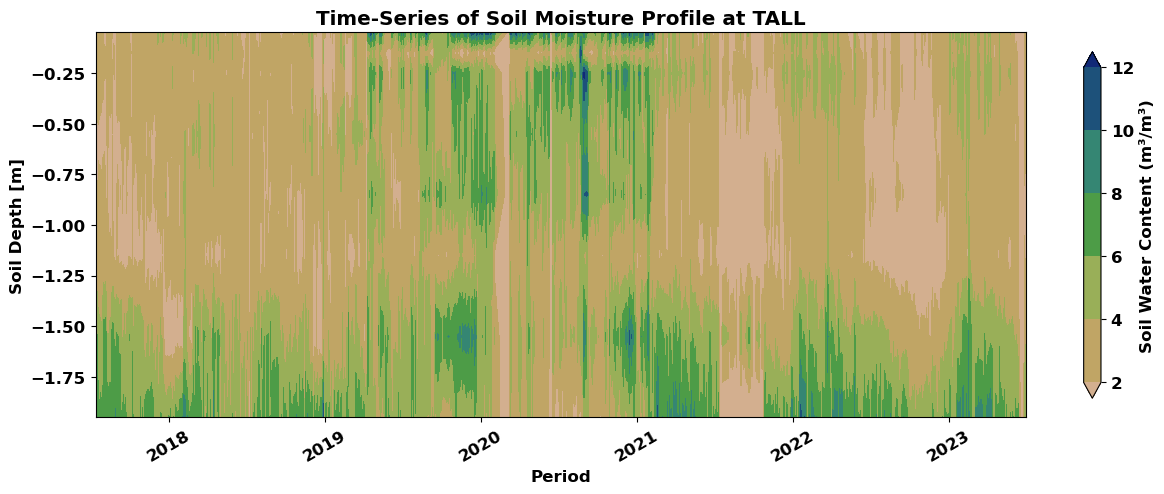

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('gist_earth_r')
cmap = truncate_colormap(cmap, 0.15, 0.9)

plt.rcParams["font.weight"] = "bold"    
plt.rcParams["axes.labelweight"] = "bold"
font = {'weight': 'bold',
            'size': 12}
plt.rc('font', **font)

fig= plt.figure(num=None, figsize=(15,5),  facecolor='w', edgecolor='k')
ax = plt.gca()
cs = ax.contourf(X, Y, plot_var,cmap=cmap,extend="both")
plt.xticks(rotation=30)
plt.ylabel('Soil Depth [m]')
plt.xlabel('Period')
plt.title ('Time-Series of Soil Moisture Profile at TALL',fontweight="bold")
cbar = fig.colorbar(cs, ax=ax, shrink=0.9)
y_label = 'Soil Water Content (m³/m³)'
cbar.ax.set_ylabel(y_label)
plt.show()

This section demonstrated the process of downloading, cleaning, and visualizing NEON soil moisture data to create a time-series plot of soil moisture profiles. You can adapt this approach to analyze data from other plots, depths, and time periods.